In [1]:
import tensorflow as t
import os

import cv2
import numpy as np
from matplotlib import pyplot as plt

# Importar dependencias para el modelo
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D

# Importar dependencias para guardar el modelo
from tensorflow.python.keras.models import save_model, load_model

In [2]:
data_dir = 'data-adversarial-training'

# Mostrar una imagen con matplotlib usando cv2 para corregir los colores
def mostrarImagen(img: cv2.typing.MatLike):
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [3]:
datos = t.keras.utils.image_dataset_from_directory(
    data_dir,
    batch_size=32,  # Tamaño de lote de datos
)
# Creamos un iterador para recorrer los datos
iterador_datos = datos.as_numpy_iterator()
lote_datos = iterador_datos.next() # Si tenemos error implica que las imágenes tienen formatos incorrectos.

Found 693 files belonging to 4 classes.


In [4]:
lote_datos # (imagenes, etiquetas)

(array([[[[140.      , 152.      , 168.      ],
          [140.      , 154.      , 165.      ],
          [136.      , 155.      , 161.      ],
          ...,
          [125.      , 142.      , 152.      ],
          [142.      , 157.      , 164.      ],
          [145.      , 160.      , 165.      ]],
 
         [[140.      , 154.      , 167.      ],
          [135.      , 152.      , 162.      ],
          [136.      , 155.      , 161.      ],
          ...,
          [133.      , 150.      , 158.      ],
          [140.      , 157.      , 165.      ],
          [138.      , 155.      , 162.      ]],
 
         [[135.      , 156.      , 161.      ],
          [135.      , 156.      , 161.      ],
          [140.      , 159.      , 166.      ],
          ...,
          [165.      , 182.      , 189.      ],
          [139.      , 157.      , 167.      ],
          [144.      , 164.      , 175.      ]],
 
         ...,
 
         [[161.      , 151.      , 139.      ],
          [216.   

In [5]:
# Diccionario de etiquetas
nombre_etiqueta = {
    0: 'Señal Máx. 120Km/h',
    1: 'Señal Máx. 50Km/h',
    2: 'Señal Radar',
    3: 'Señal STOP'
}

def mostrarPrediccion(yhat: np.ndarray,img):

    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title('Prediccion: {}'.format(nombre_etiqueta[np.argmax(yhat)]))
    plt.show()

In [6]:
datos = datos.map(lambda x,y: (x/255, y))

In [7]:
iterador_datos = datos.as_numpy_iterator()
lote_datos = iterador_datos.next()

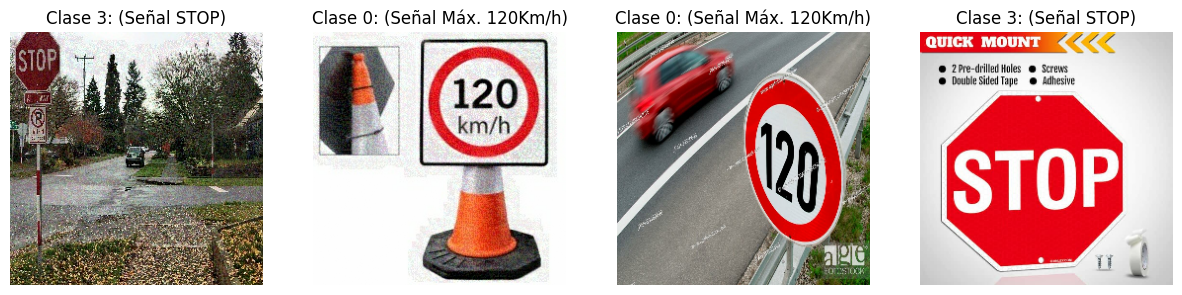

In [8]:
# Mostrar las clases de las imágenes con ejemplo
fig, axs = plt.subplots(1, 4, figsize=(15, 15),sharey=True)
for idx,img in enumerate(lote_datos[0][:4]):
    axs[idx].imshow(img)
    clase = lote_datos[1][idx]
    axs[idx].set_title('Clase {}: ({})'.format(clase,nombre_etiqueta[clase]))
    axs[idx].axis('off')

In [9]:
size_entrenamiento = int(len(datos) * 0.7)
size_validacion = int(len(datos) * 0.15) + 1
size_test = int(len(datos) * 0.15) + 1

#len(datos) == size_entrenamiento + size_validacion + size_test

In [10]:
particion_entrenamiento = datos.take(size_entrenamiento)
particion_validacion = datos.skip(size_entrenamiento).take(size_validacion)
particion_test = datos.skip(size_entrenamiento + size_validacion)

In [11]:
modelo  = Sequential() # Inicializar el modelo

In [12]:
modelo.add(Conv2D(16, (3, 3),1 , activation='relu', input_shape=(256, 256, 3))) # Capa de convolución
modelo.add(MaxPooling2D()) # Capa de pooling

modelo.add(Conv2D(32, (3, 3),1 , activation='relu')) # Capa de convolución
modelo.add(MaxPooling2D()) # Capa de pooling

modelo.add(Conv2D(16, (3, 3),1 , activation='relu')) # Capa de convolución
modelo.add(MaxPooling2D()) # Capa de pooling

modelo.add(Flatten()) # Aplanar la imagen

modelo.add(Dense(256, activation='relu')) # Capa densa
modelo.add(Dense(4, activation='softmax')) # Capa densa

In [13]:
# Compilar el modelo
modelo.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [14]:
# Ver las estadísticas del modelo generado
modelo.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 16)        4624      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 14400)             0

In [15]:
# Seleccionar directorio para guardar los logs
logs_dir = 'logs-adversarial-training'
tensorboard_callback = t.keras.callbacks.TensorBoard(log_dir=logs_dir, histogram_freq=1)

In [17]:
# Entrenar el modelo y guardar los logs
hist = modelo.fit(particion_entrenamiento, validation_data=particion_validacion, epochs=20, callbacks=[tensorboard_callback])

Epoch 1/20
15/15 [==============================] - 9s 543ms/step - loss: 1.7014e-04 - accuracy: 1.0000 - val_loss: 1.8255e-04 - val_accuracy: 1.0000
Epoch 2/20
15/15 [==============================] - 8s 521ms/step - loss: 1.5588e-04 - accuracy: 1.0000 - val_loss: 1.3885e-04 - val_accuracy: 1.0000
Epoch 3/20
 9/15 [=================>............] - ETA: 2s - loss: 1.1199e-04 - accuracy: 1.0000

KeyboardInterrupt: 

In [ ]:
# Evaluar la precisión del modelo
fig = plt.figure()
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Precisión del modelo')
plt.ylabel('Precisión')
plt.xlabel('Época')
plt.legend(['Entrenamiento', 'Validación'], loc='upper left')
plt.show()

In [ ]:
modelo.save(os.path.join('models','SignAdversaryTrainedClassifier.h5'))

Testeo

In [ ]:
img = cv2.imread('test-50.jpg')
resize = t.image.resize(img, [256, 256])

In [ ]:
yhat = modelo.predict(np.expand_dims(resize/255, axis=0))

In [ ]:
mostrarPrediccion(yhat,img)